In [ ]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 

Please input your choice of dataset, 'mnist' or 'f_mnist'
mnist
11493376/11490434 [==============================] - 0s 0us/step

Shape of data: (60000, 28, 28, 1), Data type: <dtype: 'float32'>



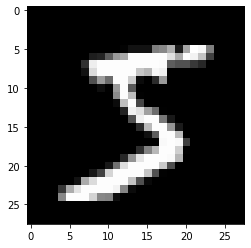

In [ ]:
f_mnist = tf.keras.datasets.fashion_mnist
mnist = tf.keras.datasets.mnist

statement = "Please input your choice of dataset, 'mnist' or 'f_mnist'"
print(statement)
if input()=='f_mnist':
    (x_train, y_train), (x_test, y_test) = f_mnist.load_data()
else:
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

def norm_cast(inp):
    '''
    Normalizing and casting data to float32
    '''
    return tf.expand_dims(tf.cast((inp/255.0), dtype=tf.float32), -1)

x_train, x_test = norm_cast(x_train), norm_cast(x_test)
y_train, y_test = tf.cast(y_train, tf.int32), tf.cast(y_test, tf.int32)
print()
print('Shape of data: {}, Data type: {}'.format(x_train.shape, x_train.dtype))
print()
for img in x_train:
    plt.imshow(np.reshape(img,(28,28)), cmap = 'gray')
    plt.show()
    break

#Hyperparameter

---

In [ ]:
#hyperparameter
BATCH_SIZE = 256
lr = 0.001
buffer_size = x_train.shape[0]
repetition = 10

#shuffle, repeat, batch
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size).repeat(repetition).batch(BATCH_SIZE)
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

#Helper Functions

---

In [ ]:
#plot function      
def plot_comparison(input_img, caption, n_row=1, n_col=2, figsize=(5, 5), cmap = 'gray', norm = None):
    '''
    Plot comparison of multiple image but only in column wise!
    :param input_img: Input image list
    :param caption: Input caption list
    :param IMG_SIZE: Image size
    :param n_row: Number of row is 1 by DEFAULT
    :param n_col: Number of columns
    :param figsize: Figure size during plotting
    :return: Plot of (n_row, n_col)
    '''
    print()
    assert len(caption) == len(input_img), "Caption length and input image length does not match"
    assert len(input_img) == n_col, "Error of input images or number of columns!"

    fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i in range(n_col):
        axes[i].imshow(np.squeeze(input_img[i]), cmap= cmap, norm=norm)
        axes[i].set_xlabel(caption[i])
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    plt.show()

def plot_loss(loss_list, xlabel, ylabel, title, recon_list=None):
    '''
    :param loss_list: List containing total loss values
    :param recon_list: List containing reconstruction loss
    :param xlabel: string for xlabel
    :param ylabel: string for ylabel
    :param title: string for title

    :return: loss value plot
    '''
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(linestyle='dotted')
    plt.plot(loss_list)

def layers_name(model):
    '''
    Retrieve key/name of layers
    :param model: Network model
    :return:
        Layers name list
    '''
    layer_dict = layers_dict(model)
    key_list = []
    for key, value in layer_dict.items():
        key_list.append(key)
        print(key)
    return key_list

def layers_dict(model):
    '''
    :param model: deep learning model

    :return:
        Dictionary with 'key': layer names, value: layer information
    '''
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    return layer_dict

def feature_maps(model, layer_name, inps):
    '''
    This function visualize the intermediate activations of the filters within the layers
    :param model: deep learning model
    :param layer_name: desired layer name, if forgotten, please refer to layers_dict function
    :param inps: feed the network with input, such as images, etc. input dimension
                 should be 4.

    :return:
        feature maps of the layer specified by layer name,
        with dimension ( batch, row size, column size, channels)
    '''
    assert inps.ndim == 4, "Input tensor dimension not equal to 4!"
    # retrieve key value from layers_dict
    layer_dict = layers_dict(model)

    # layer output with respect to the layer name
    layer_output = layer_dict[layer_name].output
    viz_model = Model(inputs=model.inputs, outputs=layer_output)
    feature_maps = viz_model.predict(inps)

    print('Shape of feature maps:', feature_maps.shape)
    # shape (batch, row size, column size, channels)
    return feature_maps


def plot_feature_maps(inps, row_num, col_num, figsize):
    '''
    This function can only plot the feature maps of a model
    :param inps: feature maps
    :param row_num: number of rows for the plot
    :param col_num: number of columns for the plot

    :return:
        grid plot of size (row_num * col_num)
    '''
    assert inps.ndim == 4, "Input tensor dimension not equal to 4!"

    print("Number of feature maps in layer: ", inps.shape[-1])

    fig, axes = plt.subplots(row_num, col_num, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i, ax in enumerate(axes.flat):
        img = inps[0, :, :, i]

        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

def layer_shape(model, layer_name=None):
    '''
    This function aims to retrieve the layer shape
    of a model by its name, this is particularly useful
    for plotting the feature maps
    '''
    #print shape for all layers
    if layer_name==None:
        for layers in model.layers:
            print(layers.output_shape)
    #print shape for that particular layer given name
    else:
        print(model.get_layer(layer_name).output_shape)


---

#Model Functions 

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Reshape
#model 
def Dense_encoder(inps, latent_dim=20):
    if tf.rank(inps)!=2: #if the input images are not reshape
        flatten01 = Flatten()(inps)
    else:
        flatten01 = inps
    dense01 = Dense(256, activation = 'relu')(flatten01)
    dense02 = Dense(128, activation = 'relu')(dense01)
    dense03 = Dense(64,activation = 'relu')(dense02)
    latent_space = Dense(latent_dim, activation = 'relu')(dense03)
    return latent_space 

def Dense_decoder(latent_space, last_acti=None):
    if tf.rank(latent_space)!=2: #connecting from a non-dense latent-space
        flatten01 = Flatten()(latent_space)
    else:
        flatten01 = latent_space
    dense01 = Dense(64, activation = 'relu')(flatten01)
    dense02 = Dense(128, activation = 'relu')(dense01)
    dense03 = Dense(256, activation = 'relu')(dense02)
    dense04 = Dense(28*28, activation = last_acti)(dense03)
    output = Reshape((-1,28,28))(dense04)
    return output

def Conv_encoder(inps, latent_dim=20):
    conv01 = Conv2D(128, 3, padding='same', activation='relu')(inps)
    pool01 = MaxPooling2D(strides=2)(conv01)
    conv02 = Conv2D(64, 3, padding='same', activation='relu')(pool01)
    pool02 = MaxPooling2D(strides=2)(conv02)
    latent_space = Conv2D(latent_dim, 3, padding='same', activation='relu')(pool02)
    return latent_space

def Conv_decoder(latent_space, last_acti=None):
    if tf.rank(latent_space)==2: #if connected to dense layer
        dense01 = Dense(7*7*25, activation = 'relu')(latent_space)
        re_inp = Reshape((7,7,25))(dense01)
    else:
        re_inp = latent_space
    upsam01 = UpSampling2D()(re_inp)
    conv01 = Conv2D(128, 3,padding ='same', activation ='relu')(upsam01)
    upsam02 = UpSampling2D()(conv01)
    conv02 = Conv2D(64, 3,padding ='same', activation ='relu')(upsam02)
    output = Conv2D(1, 3, padding='same', activation = last_acti)(conv02)
    return output

def last_layer_shape(inp_model):
    '''
    This function retrieve the shape of the model last layer 
    omitting the 'None' dimension
    '''
    last_layer = inp_model.layers[-1].output_shape #(None, filters)
    dims = len(last_layer)
    #for dense as last layer
    if dims == 2:
        shape = last_layer[-1]
    else:
        shape=[]
        for i in range(1, dims):
            shape.append(last_layer[i])
    return shape

#build model in the call function     
def build(inp_shape, encoder=None, decoder=None):
    #case insensitve for input string
    encoder, decoder = encoder.lower(), decoder.lower()
    assert (encoder=='dense' 
            or decoder=='dense' 
            or encoder == 'conv' 
            or decoder == 'conv'),"Please input 'Dense' or 'Conv' (case insensitive)!" 
    en_inps = Input(shape=inp_shape)
    # dense encoder dense decoder
    if encoder=='dense' and decoder=='dense':
        en_model = Model(en_inps, Dense_encoder(en_inps))
        dec_inps = Input(shape=last_layer_shape(en_model))
        de_model = Model(dec_inps, Dense_decoder(dec_inps))
    #conv encoder and conv decoder
    if encoder=='conv' and decoder=='conv':
        en_model = Model(en_inps, Conv_encoder(en_inps))
        dec_inps = Input(shape=last_layer_shape(en_model))
        de_model = Model(dec_inps, Conv_decoder(dec_inps))
    #conv encoder and dense decoder
    if encoder=='conv' and decoder=='dense':
        en_model = Model(en_inps, Conv_encoder(en_inps))
        dec_inps = Input(shape=last_layer_shape(en_model))
        de_model = Model(dec_inps, Dense_decoder(dec_inps))
    #dense encoder and conv decoder
    if encoder=='dense' and decoder=='conv':
        en_model = Model(en_inps, Dense_encoder(en_inps))
        dec_inps = Input(shape=last_layer_shape(en_model))
        de_model = Model(dec_inps, Conv_decoder(dec_inps))
    
    return en_model, de_model

---

# Train Model

Steps: 0, Loss:0.10709879547357559
Reconstructed Image: 



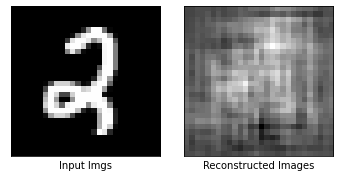

Steps: 100, Loss:0.007871472276747227
Reconstructed Image: 



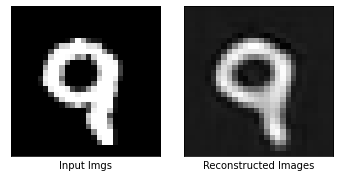

Steps: 200, Loss:0.006526639219373465
Reconstructed Image: 



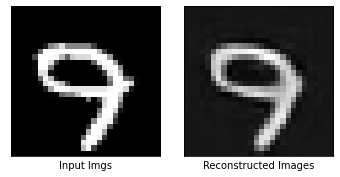

Steps: 300, Loss:0.003970087971538305
Reconstructed Image: 



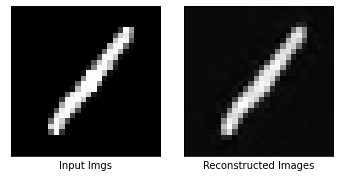

Steps: 400, Loss:0.0032666593324393034
Reconstructed Image: 



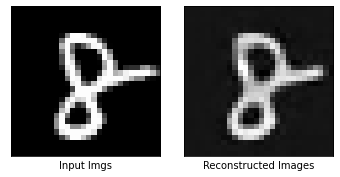

Steps: 500, Loss:0.0029304714407771826
Reconstructed Image: 



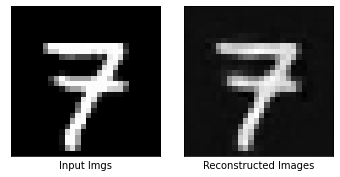

Steps: 600, Loss:0.0026647087652236223
Reconstructed Image: 



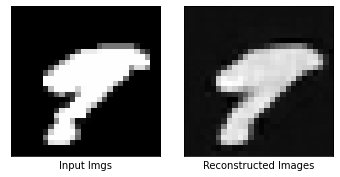

Steps: 700, Loss:0.0024707182310521603
Reconstructed Image: 



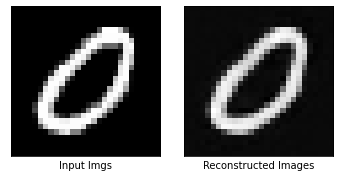

Steps: 800, Loss:0.0023307609371840954
Reconstructed Image: 



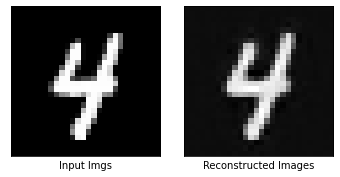

Steps: 900, Loss:0.0021776321809738874
Reconstructed Image: 



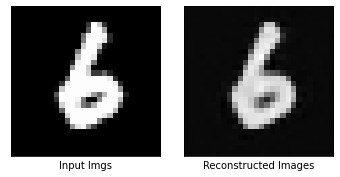

Steps: 1000, Loss:0.0022296744864434004
Reconstructed Image: 



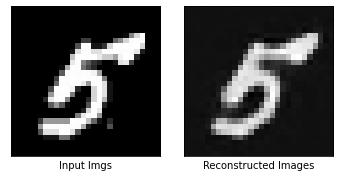

Steps: 1100, Loss:0.0019873136188834906
Reconstructed Image: 



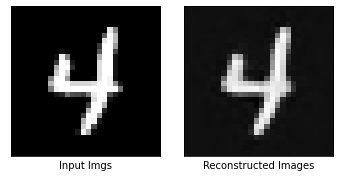

Steps: 1200, Loss:0.0019544842652976513
Reconstructed Image: 



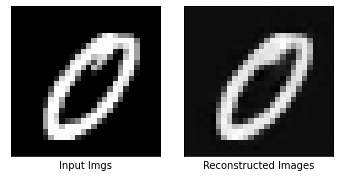

Steps: 1300, Loss:0.0018703211098909378
Reconstructed Image: 



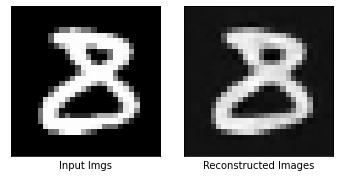

Steps: 1400, Loss:0.0017898741643875837
Reconstructed Image: 



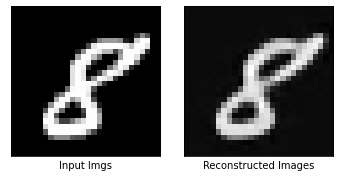

Steps: 1500, Loss:0.00185035087633878
Reconstructed Image: 



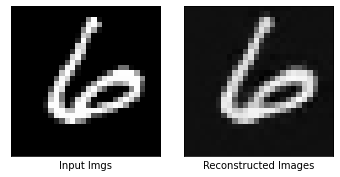

Steps: 1600, Loss:0.0017269197851419449
Reconstructed Image: 



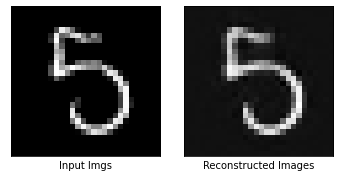

Steps: 1700, Loss:0.001687489915639162
Reconstructed Image: 



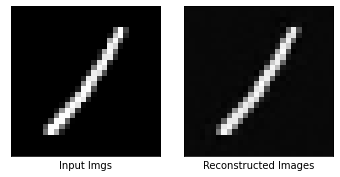

Steps: 1800, Loss:0.00153961475007236
Reconstructed Image: 



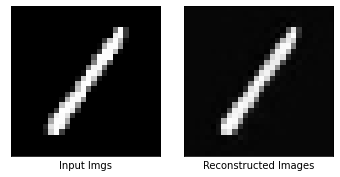

Steps: 1900, Loss:0.0016367635689675808
Reconstructed Image: 



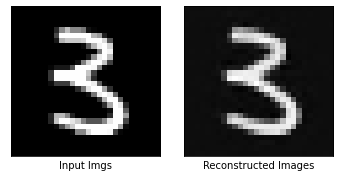

Steps: 2000, Loss:0.0015214121667668223
Reconstructed Image: 



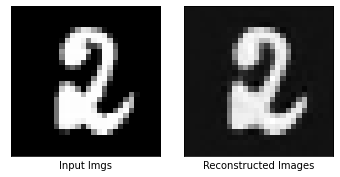

In [ ]:
en_model, de_model = build((28,28,1), encoder = 'conv', decoder = 'conv')
opt = tf.keras.optimizers.Adam(lr)
mse = tf.keras.losses.MeanSquaredError()

@tf.function
def train_fn(imgs, lbls):
    with tf.GradientTape() as tape:
        #encoder
        encode = en_model(imgs)
        #decoder for reconstructing the images
        reconstruction = de_model(encode)
        re_loss = mse(imgs, reconstruction)
    varis = en_model.trainable_variables + de_model.trainable_variables 
    gradients = tape.gradient(re_loss, varis)
    opt.apply_gradients(zip(gradients, varis))

    return reconstruction, re_loss

loss_list = []   
for steps, (img_batch, lbl_batch) in enumerate(ds_train):
    if steps>2000:
        break
        
    reconstruction, re_loss = train_fn(img_batch, lbl_batch)
    loss_list.append(re_loss)
    if not steps %100: 
        input_img = [img_batch[0], reconstruction[0]]
        captions = ['Input Imgs', 'Reconstructed Images']
        print('Steps: {}, Loss:{}'.format(steps, re_loss))
        print('Reconstructed Image: ')
        plot_comparison(input_img, captions, n_row=1, n_col=len(input_img), figsize=(5, 5))

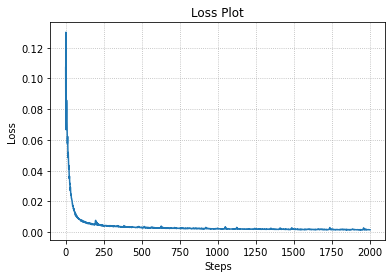

In [ ]:
xlabel = 'Steps'
ylabel = 'Loss'
title = 'Loss Plot'
plot_loss(loss_list, xlabel, ylabel, title, recon_list=None)

In [ ]:
#save weights
en_model.save_weights("encoder_model.h5")

---

#Visualizing Filters

## Feature Maps for Decoder 

In [ ]:
de_name = layers_name(de_model)

input_2
up_sampling2d
conv2d_3
up_sampling2d_1
conv2d_4
conv2d_5


In [ ]:
layer_shape(de_model, 'conv2d_3')

(None, 14, 14, 128)


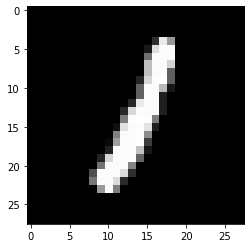

In [ ]:
n_rand = np.random.randint(x_train.shape[0])
img_rand = tf.expand_dims(x_train[n_rand],0)
plt.imshow(np.squeeze(img_rand), cmap = 'gray')

Shape of feature maps: (1, 14, 14, 128)
Number of feature maps in layer:  128


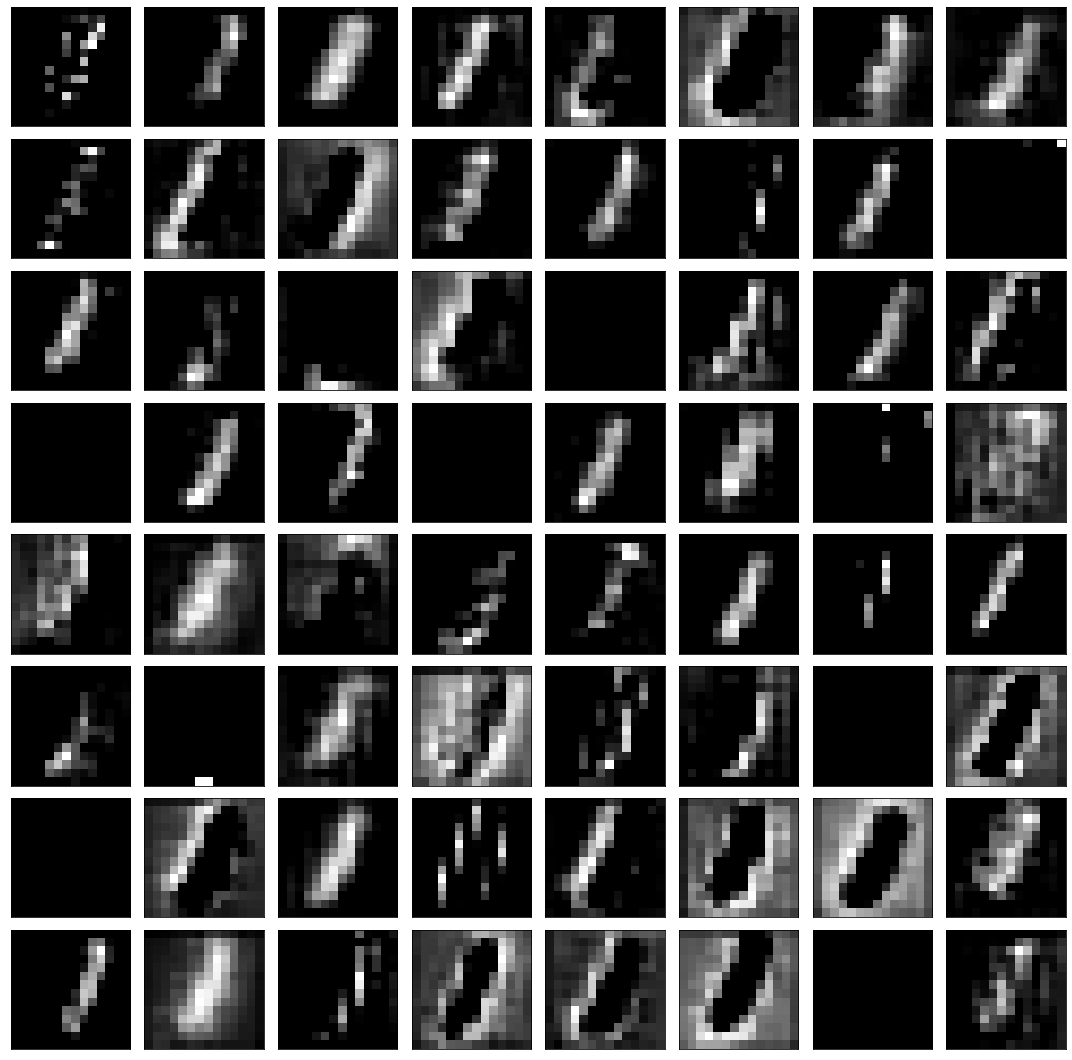

In [ ]:
feature_maps01 = feature_maps(de_model, 'conv2d_3', en_model(img_rand))
plot_feature_maps(feature_maps01, 8, 8, figsize=(15,15))

## Feature Maps for Encoder

In [ ]:
en_name = layers_name(en_model)

input_1
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2


In [ ]:
layer_shape(en_model, 'conv2d')

(None, 28, 28, 128)


Shape of feature maps: (1, 28, 28, 128)
Number of feature maps in layer:  128


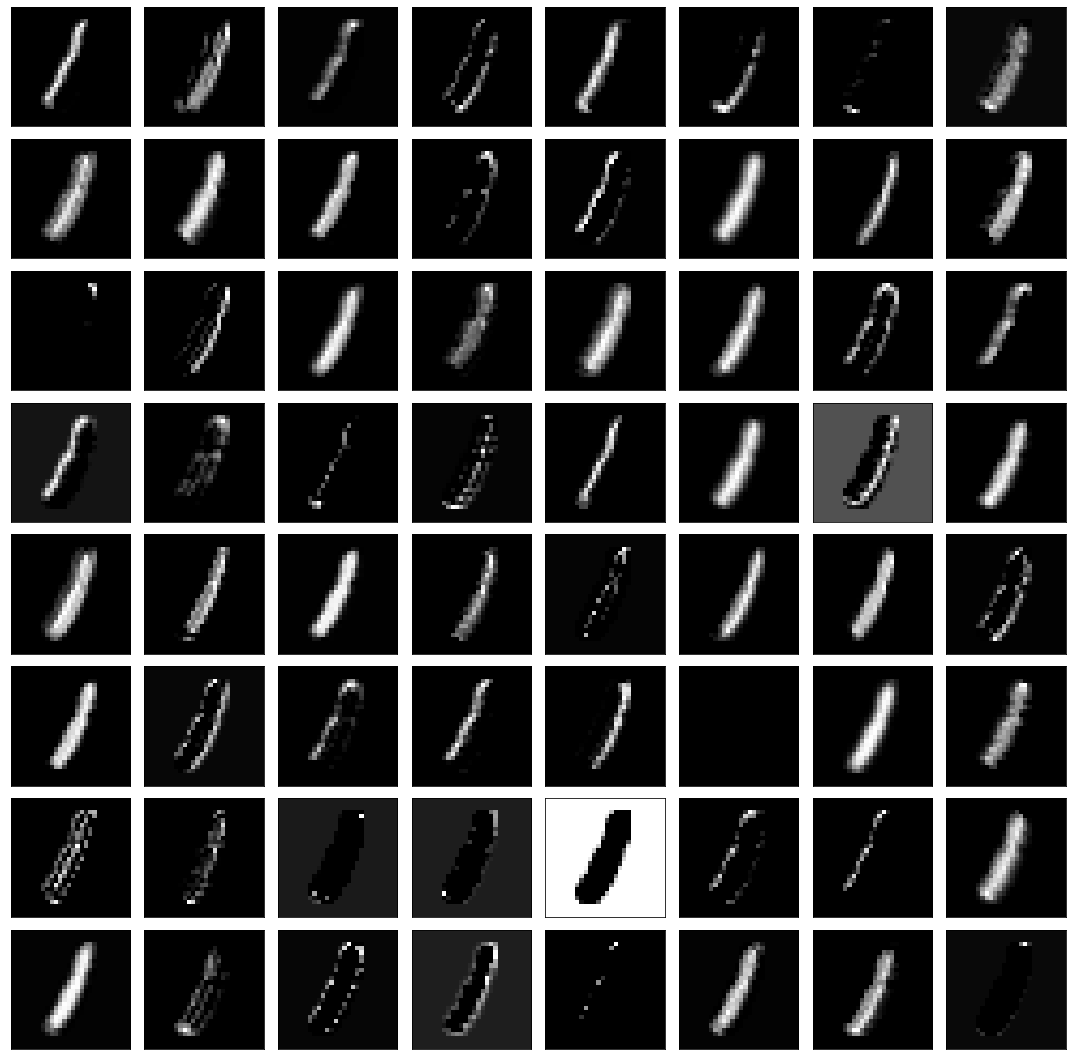

In [ ]:
feature_maps02 = feature_maps(en_model, 'conv2d', img_rand)
plot_feature_maps(feature_maps02, 8, 8, figsize=(15,15))

---

# Walking the Code Space

In [ ]:
#last layer is the latent dim 
print(last_layer_shape(en_model))

[7, 7, 20]


In [ ]:
latent_space = feature_maps(en_model, 'conv2d_2', img_rand)

Shape of feature maps: (1, 7, 7, 20)


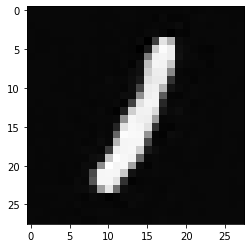

In [ ]:
#original latent space
re_01 = de_model(latent_space)
plt.imshow(np.squeeze(re_01), cmap ='gray')

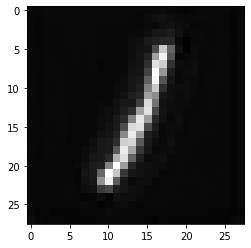

In [ ]:
scale = 0.1
latent_space02 = []
#scale each feature maps in the dimension space
for i in range(latent_space.shape[-1]):
    latent_space02.append(scale*tf.squeeze(latent_space)[:,:,i])
latent_space02 = tf.transpose(tf.expand_dims(tf.convert_to_tensor(latent_space02),-1),[3,1,2,0])
re_02 = de_model(latent_space02)
plt.imshow(np.squeeze(re_02), cmap ='gray')

Shape of feature maps: (1, 14, 14, 128)
Number of feature maps in layer:  128


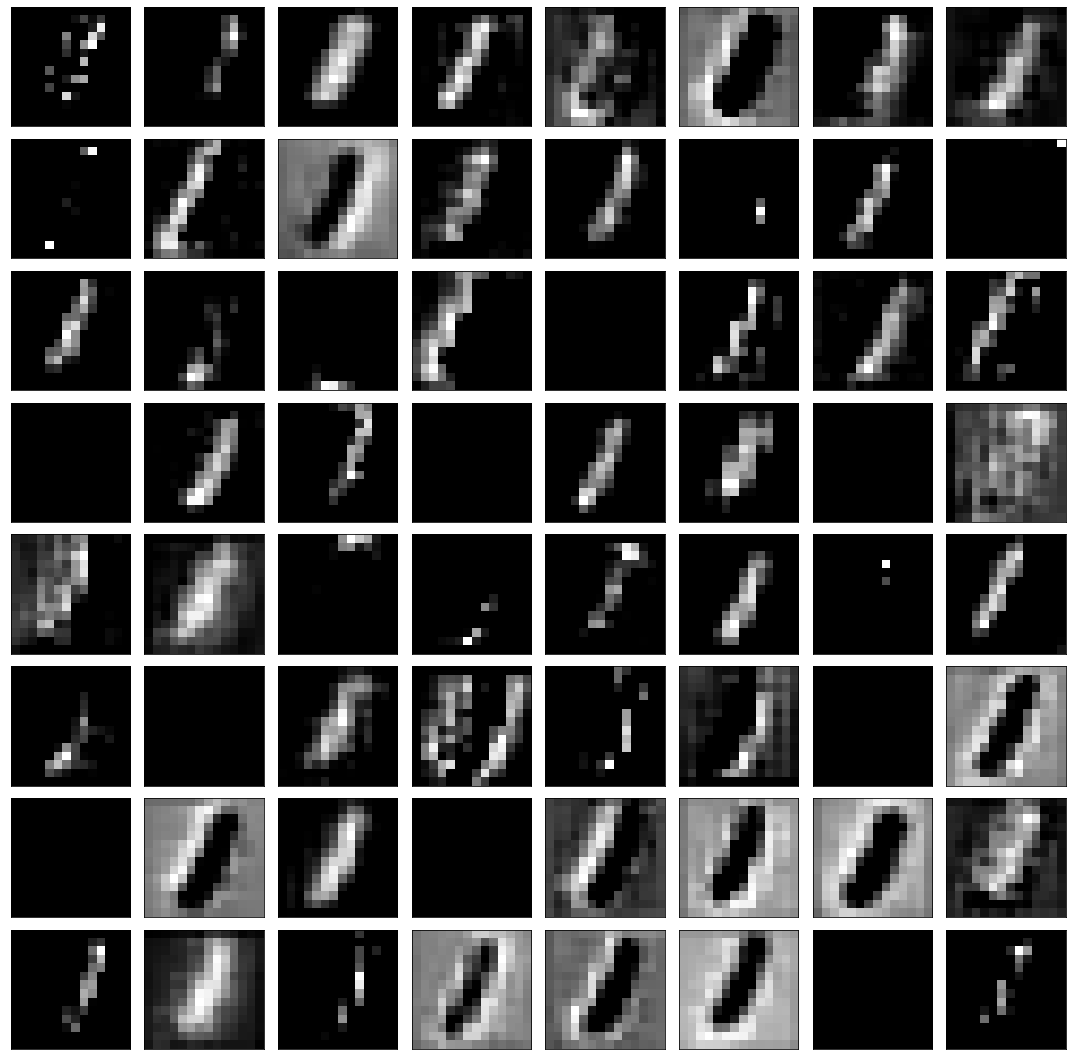

In [ ]:
feature_maps01 = feature_maps(de_model, 'conv2d_3', latent_space02)
plot_feature_maps(feature_maps01, 8, 8, figsize=(15,15))

---

#Unsupervised Pretraining


In [ ]:
def classify_layer(latent_space):
    if tf.rank(latent_space)!=2:
        latent_space = Flatten()(latent_space)
    logits = Dense(10)(latent_space)
    return logits

In [ ]:
#build classifier 
inps = Input(last_layer_shape(en_model))
classifier = Model(inps, classify_layer(inps))

In [ ]:
classifier.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 7, 7, 20)]        0         
_________________________________________________________________
flatten (Flatten)            (None, 980)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                9810      
Total params: 9,810
Trainable params: 9,810
Non-trainable params: 0
_________________________________________________________________


Train autoencoder – freeze encoder – train classifier on top (as described above)

Steps: 0, Loss:0.0015214121667668223, Acc: 0.09765625


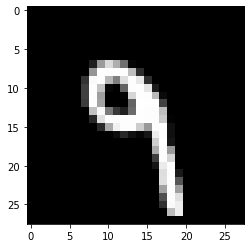

Actual label:9, Predicted label: 4

Steps: 100, Loss:0.0015214121667668223, Acc: 0.9296875


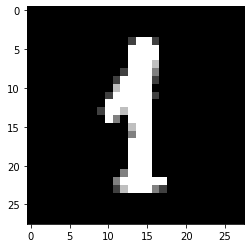

Actual label:1, Predicted label: 1

Steps: 200, Loss:0.0015214121667668223, Acc: 0.87109375


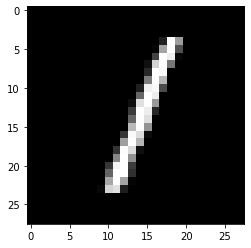

Actual label:1, Predicted label: 1

Steps: 300, Loss:0.0015214121667668223, Acc: 0.9453125


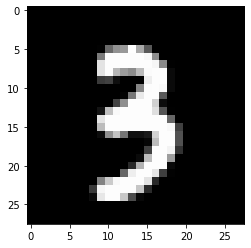

Actual label:3, Predicted label: 3

Steps: 400, Loss:0.0015214121667668223, Acc: 0.93359375


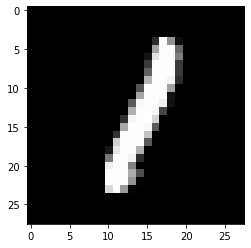

Actual label:1, Predicted label: 1

Steps: 500, Loss:0.0015214121667668223, Acc: 0.9453125


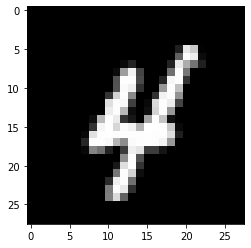

Actual label:4, Predicted label: 4

Steps: 600, Loss:0.0015214121667668223, Acc: 0.9296875


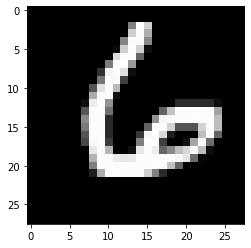

Actual label:6, Predicted label: 6

Steps: 700, Loss:0.0015214121667668223, Acc: 0.9375


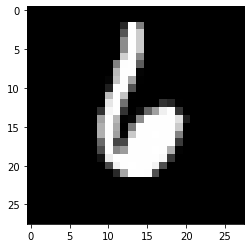

Actual label:6, Predicted label: 6

Steps: 800, Loss:0.0015214121667668223, Acc: 0.953125


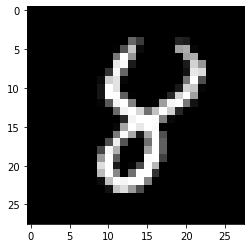

Actual label:8, Predicted label: 8

Steps: 900, Loss:0.0015214121667668223, Acc: 0.94921875


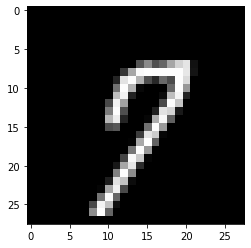

Actual label:7, Predicted label: 7

Steps: 1000, Loss:0.0015214121667668223, Acc: 0.93359375


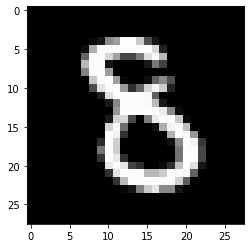

Actual label:8, Predicted label: 8



In [ ]:
en_model.load_weights("encoder_model.h5")

@tf.function
def unsupervised_train01(imgs, lbls):
    with tf.GradientTape() as tape:
        #encoder
        en_model.trainable = False #freeze layer
        encode = en_model(imgs)
        #connect encoder to classifier
        logits = classifier(encode)
        loss = tf.keras.losses.sparse_categorical_crossentropy(lbls, logits, from_logits=True)
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbls), tf.float32))
    varis = classifier.trainable_variables 
    gradients = tape.gradient(loss, varis)
    opt.apply_gradients(zip(gradients, varis))
    return loss, acc, preds
  
for steps, (img_batch, lbl_batch) in enumerate(ds_train):
    if steps>1000:
        break
    loss, acc, preds = unsupervised_train01(img_batch, lbl_batch)
    if not steps %100: 
        print('Steps: {}, Loss:{}, Acc: {}'.format(steps, re_loss, acc))
        plt.imshow(np.squeeze(img_batch[0]), cmap='gray')
        plt.show()
        print('Actual label:{}, Predicted label: {}'.format(lbl_batch[0], preds[0]))
        print()

Train autoencoder – train classifier on top of encoder. Do not freeze the encoder, i.e. the encoder is “fine-tuned” on the labeled subset of data as well.

Steps: 0, Loss:0.0015214121667668223, Acc: 0.93359375


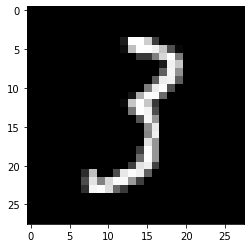

Actual label:3, Predicted label: 3

Steps: 100, Loss:0.0015214121667668223, Acc: 0.9375


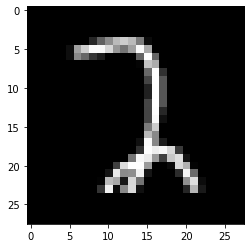

Actual label:2, Predicted label: 2

Steps: 200, Loss:0.0015214121667668223, Acc: 0.93359375


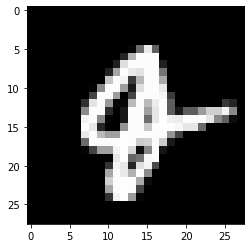

Actual label:4, Predicted label: 9

Steps: 300, Loss:0.0015214121667668223, Acc: 0.953125


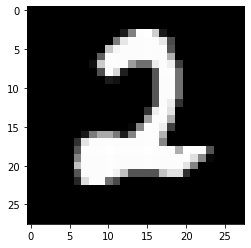

Actual label:2, Predicted label: 2

Steps: 400, Loss:0.0015214121667668223, Acc: 0.9375


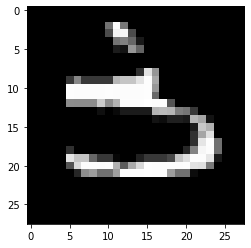

Actual label:3, Predicted label: 5

Steps: 500, Loss:0.0015214121667668223, Acc: 0.91796875


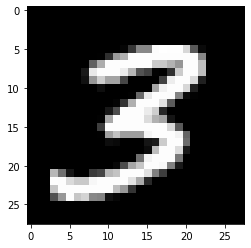

Actual label:3, Predicted label: 3

Steps: 600, Loss:0.0015214121667668223, Acc: 0.93359375


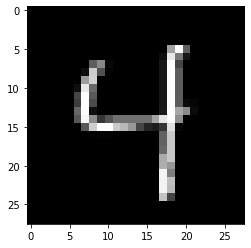

Actual label:4, Predicted label: 4

Steps: 700, Loss:0.0015214121667668223, Acc: 0.94921875


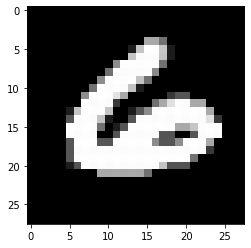

Actual label:6, Predicted label: 6

Steps: 800, Loss:0.0015214121667668223, Acc: 0.93359375


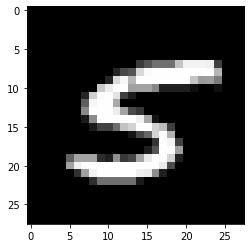

Actual label:5, Predicted label: 5

Steps: 900, Loss:0.0015214121667668223, Acc: 0.9453125


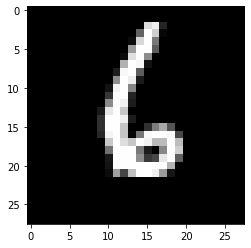

Actual label:6, Predicted label: 6

Steps: 1000, Loss:0.0015214121667668223, Acc: 0.921875


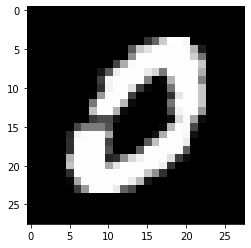

Actual label:0, Predicted label: 0



In [ ]:
#load pre trained weights
en_model.load_weights("encoder_model.h5") 

@tf.function
def unsupervised_train02(imgs, lbls):
    with tf.GradientTape() as tape:
        #encoder
        encode = en_model(imgs)
        #connect encoder to classifier
        logits = classifier(encode)
        loss = tf.keras.losses.sparse_categorical_crossentropy(lbls, logits, from_logits=True)
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbls), tf.float32))
    varis = en_model.trainable_variables + classifier.trainable_variables 
    gradients = tape.gradient(loss, varis)
    opt.apply_gradients(zip(gradients, varis))
    return loss, acc, preds
  
for steps, (img_batch, lbl_batch) in enumerate(ds_train):
    if steps>1000:
        break
    loss, acc, preds = unsupervised_train02(img_batch, lbl_batch)
    if not steps %100: 
        print('Steps: {}, Loss:{}, Acc: {}'.format(steps, re_loss, acc))
        plt.imshow(np.squeeze(img_batch[0]), cmap='gray')
        plt.show()
        print('Actual label:{}, Predicted label: {}'.format(lbl_batch[0], preds[0]))
        print()

Train a classifier directly on the labeled subset; no pretraining. For fairness, it should have the same architecture as the encoder + classifier above.

Steps: 0, Loss:0.0015214121667668223, Acc: 0.06640625


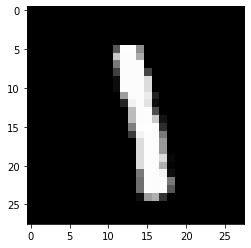

Actual label:1, Predicted label: 5

Steps: 100, Loss:0.0015214121667668223, Acc: 0.9765625


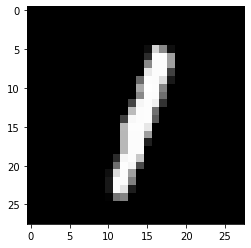

Actual label:1, Predicted label: 1

Steps: 200, Loss:0.0015214121667668223, Acc: 0.98828125


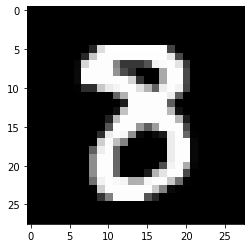

Actual label:8, Predicted label: 8

Steps: 300, Loss:0.0015214121667668223, Acc: 0.98828125


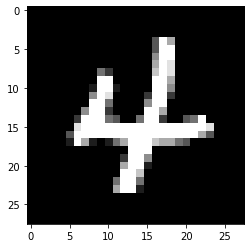

Actual label:4, Predicted label: 4

Steps: 400, Loss:0.0015214121667668223, Acc: 0.98046875


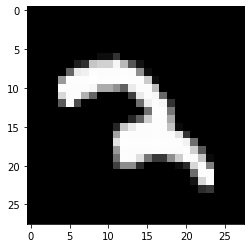

Actual label:2, Predicted label: 2

Steps: 500, Loss:0.0015214121667668223, Acc: 0.98828125


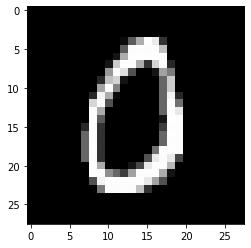

Actual label:0, Predicted label: 0

Steps: 600, Loss:0.0015214121667668223, Acc: 0.9765625


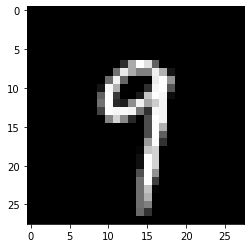

Actual label:9, Predicted label: 9

Steps: 700, Loss:0.0015214121667668223, Acc: 0.984375


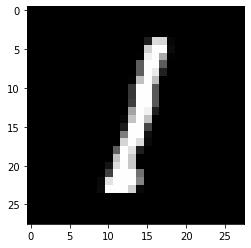

Actual label:1, Predicted label: 1

Steps: 800, Loss:0.0015214121667668223, Acc: 0.98828125


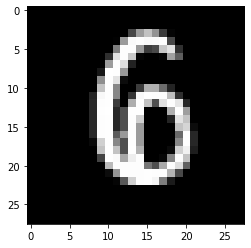

Actual label:6, Predicted label: 6

Steps: 900, Loss:0.0015214121667668223, Acc: 0.984375


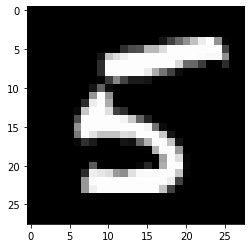

Actual label:5, Predicted label: 5

Steps: 1000, Loss:0.0015214121667668223, Acc: 0.984375


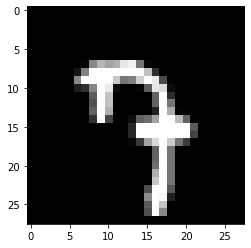

Actual label:7, Predicted label: 7



In [ ]:
#rebuild model to reset state
# en_model.reset_states()
en_model, de_model = build((28,28,1), encoder = 'conv', decoder = 'conv')
@tf.function
def unsupervised_train03(imgs, lbls):
    with tf.GradientTape() as tape:
        #encoder
        encode = en_model(imgs)
        #connect encoder to classifier
        logits = classifier(encode)
        loss = tf.keras.losses.sparse_categorical_crossentropy(lbls, logits, from_logits=True)
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbls), tf.float32))
    varis = en_model.trainable_variables + classifier.trainable_variables 
    gradients = tape.gradient(loss, varis)
    opt.apply_gradients(zip(gradients, varis))
    return loss, acc, preds
  
for steps, (img_batch, lbl_batch) in enumerate(ds_train):
    if steps>1000:
        break
    loss, acc, preds = unsupervised_train03(img_batch, lbl_batch)
    if not steps %100: 
        print('Steps: {}, Loss:{}, Acc: {}'.format(steps, re_loss, acc))
        plt.imshow(np.squeeze(img_batch[0]), cmap='gray')
        plt.show()
        print('Actual label:{}, Predicted label: {}'.format(lbl_batch[0], preds[0]))
        print()

---

#Visualizing Latent Space with t-SNE

Computing latent space projection...
Computing t-SNE embedding...
Plotting t-SNE visualization...


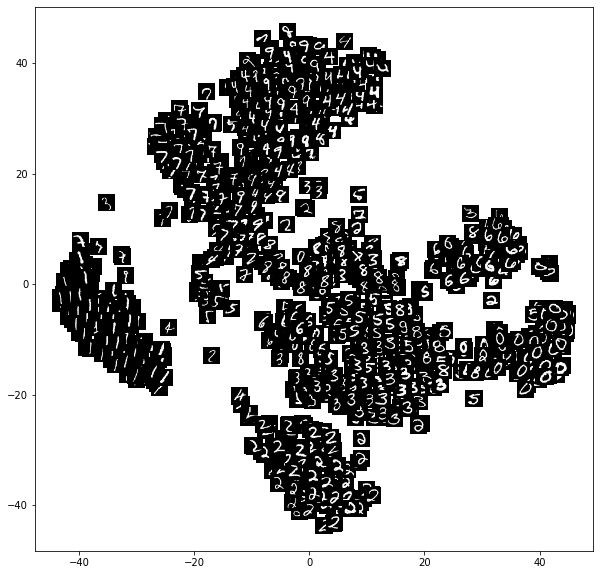

In [ ]:
import cv2
from sklearn import manifold
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

#reference from https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df
#https://github.com/despoisj/LatentSpaceVisualization/blob/master/visuals.py
def imscatter(x, y, ax, imageData, zoom):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]
        # Convert to image
        img = np.array(imageData[i]*255.)
        img = img.astype(np.uint8).reshape([28,28])
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        # Note: OpenCV uses BGR and plt uses RGB
        image = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

def computeTSNEProjectionOfLatentSpace(X, encoder, display=True, figsize=(5,5)):
    # Compute latent space representation
    print("Computing latent space projection...")
    X_encoded = encoder.predict(X)

    if tf.rank(X_encoded)!=2: #tsne takes in dim size of 2!
        X_encoded = tf.reshape(X_encoded, (X_encoded.shape[0], -1))
    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded)

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=figsize)
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.6)
        plt.show()
    else:
        return X_tsne

en_model.load_weights("encoder_model.h5") 
computeTSNEProjectionOfLatentSpace(x_test[:1000], en_model, figsize=(10,10))